In [5]:
import gzip
import io
import json
import nilearn
import os
import tarfile
import tempfile
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
from bids_validator import BIDSValidator

from io import BytesIO
from os import listdir as ls
from os.path import basename as bname
from os.path import dirname as dname
from os.path import expanduser as xpu
from os.path import join as pjoin
from pandas import DataFrame as df
from tempfile import TemporaryDirectory as tmpdir
from tempfile import TemporaryFile as tmpfile
from typing import Union

import loadutils as lu
import sniffbytes as snif
import scanzip as szip
import shutil

from nilearn import masking
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, plot_epi
from nilearn.image import concat_imgs, mean_img
from nilearn.input_data import NiftiMasker

def lst_intersection(lst1, lst2):
    '''
    Source: https://www.geeksforgeeks.org/python-intersection-two-lists/
    '''
    return [value for value in lst1 if value in set(lst2)]

def read_json(fpath:Union[str, os.PathLike]) -> dict:
    with open(fpath, mode='r', encoding='UTF-8') as jfile:
        jdict = json.load(jfile)
    jfile.close()
    return jdict
        
# with tmpfile(prefix=os.getcwd()+"/",
#             dir=os.path.splitext(bname(src_path))[0]+"/",
#             suffix=os.path.splitext(topname)[0]) as adir:
#     print(adir.name)
# tardir = xpu('~/../../data/cisl/DATA/cimaq_20190901/sourcedata')
# topname = 'cimaq_dicoms_20190901_v3.tar.gz'
# member = 'seriesUID_qc.tsv'
# tardir = '/media/francois/seagate_1tb/cimaq_dicoms_20190901'
# help(tempfile)
# src_path = pjoin(tardir, topname)


In [6]:
source_url = 'https://nilearn.github.io/auto_examples/02_decoding/plot_haxby_searchlight.html#sphx-glr-auto-examples-02-decoding-plot-haxby-searchlight-py'
import pandas as pd
from nilearn import datasets
from nilearn.image import new_img_like, load_img, get_data

# We fetch 2nd subject from haxby datasets (which is default)
haxby_dataset = datasets.fetch_haxby()

# print basic information on the dataset
print('Anatomical nifti image (3D) is located at: %s' % haxby_dataset.mask)
print('Functional nifti image (4D) is located at: %s' % haxby_dataset.func[0])

fmri_filename = haxby_dataset.func[0]
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
y = labels['labels']
session = labels['chunks']


Anatomical nifti image (3D) is located at: /home/fnadeau/nilearn_data/haxby2001/mask.nii.gz
Functional nifti image (4D) is located at: /home/fnadeau/nilearn_data/haxby2001/subj2/bold.nii.gz


In [20]:
y[labels['labels'].isin(['face', 'house'])]

21      face
22      face
23      face
24      face
25      face
        ... 
1398    face
1399    face
1400    face
1401    face
1402    face
Name: labels, Length: 216, dtype: object

In [8]:
from nilearn.image import index_img
condition_mask = y.isin(['face', 'house'])

fmri_img = index_img(fmri_filename, condition_mask)
y, session = y[condition_mask], session[condition_mask]
y

21      face
22      face
23      face
24      face
25      face
        ... 
1398    face
1399    face
1400    face
1401    face
1402    face
Name: labels, Length: 216, dtype: object

In [9]:
condition_mask

0       False
1       False
2       False
3       False
4       False
        ...  
1447    False
1448    False
1449    False
1450    False
1451    False
Name: labels, Length: 1452, dtype: bool

In [10]:
import numpy as np

# 3D mask
mask_img = load_img(haxby_dataset.mask)

# .astype() makes a copy.
process_mask = get_data(mask_img).astype(np.int)
picked_slice = 29
process_mask[..., (picked_slice + 1):] = 0
process_mask[..., :picked_slice] = 0
process_mask[:, 30:] = 0
process_mask_img = new_img_like(mask_img, process_mask)


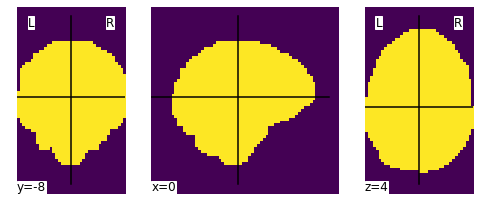

In [11]:
nilearn.plotting.plot_img(mask_img)

In [12]:
# Make processing parallel
# /!\ As each thread will print its progress, n_jobs > 1 could mess up the
#     information output.
n_jobs = 1

# Define the cross-validation scheme used for validation.
# Here we use a KFold cross-validation on the session, which corresponds to
# splitting the samples in 4 folds and make 4 runs using each fold as a test
# set once and the others as learning sets
from sklearn.model_selection import KFold
cv = KFold(n_splits=4)

import nilearn.decoding
# The radius is the one of the Searchlight sphere that will scan the volume
searchlight = nilearn.decoding.SearchLight(
    mask_img,
    process_mask_img=process_mask_img,
    radius=5.6, n_jobs=n_jobs,
    verbose=1, cv=cv)
searchlight.fit(fmri_img, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.9s finished


SearchLight(cv=KFold(n_splits=4, random_state=None, shuffle=False),
            mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f8b65af7750>,
            process_mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f8b65b24110>,
            radius=5.6, verbose=1)

In [13]:
from nilearn.input_data import NiftiMasker

# For decoding, standardizing is often very important
nifti_masker = NiftiMasker(mask_img=mask_img, sessions=session,
                           standardize=True, memory='nilearn_cache',
                           memory_level=1)
fmri_masked = nifti_masker.fit_transform(fmri_img)

from sklearn.feature_selection import f_classif
f_values, p_values = f_classif(fmri_masked, y)
p_values = -np.log10(p_values)
p_values[p_values > 10] = 10
p_unmasked = get_data(nifti_masker.inverse_transform(p_values))


/home/fnadeau/myenv/lib/python3.7/site-packages/nilearn/_utils/helpers.py:145: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  return func(*args, **kwargs)


/home/fnadeau/myenv/lib/python3.7/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])


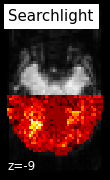

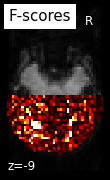

In [14]:
from nilearn import image
mean_fmri = image.mean_img(fmri_img)

from nilearn.plotting import plot_stat_map, plot_img, show
searchlight_img = new_img_like(mean_fmri, searchlight.scores_)

# Because scores are not a zero-center test statistics, we cannot use
# plot_stat_map
plot_img(searchlight_img, bg_img=mean_fmri,
         title="Searchlight", display_mode="z", cut_coords=[-9],
         vmin=.42, cmap='hot', threshold=.2, black_bg=True)

# F_score results
p_ma = np.ma.array(p_unmasked, mask=np.logical_not(process_mask))
f_score_img = new_img_like(mean_fmri, p_ma)
plot_stat_map(f_score_img, mean_fmri,
              title="F-scores", display_mode="z",
              cut_coords=[-9],
              colorbar=False)

show()